# Training the 231M MLP and beat ASCADv2 dataset in a Non-Worst-Case setting

This notebook allows you to reproduce the training of the strong DL-SCA attack against the ASCADv2 dataset in a Non-Worst-Case setting. The attack is based on the paper "Scoop: An Optimization Algorithm for Profiling Attacks against Higher-Order Masking".

It requires you to download the ASCADv2 ecxtracted dataset from the [ANSSI website](https://www.data.gouv.fr/fr/datasets/ascadv2/) and to place it in the correct folder (see the second python cell). It requires you to have a GPU to run the attack, and also to have at least 32GB free of RAM. Dynamic allocations "per batch" are used to reduce the memory consumption so it should run on most middle-range GPUs. Keep in mind that it is a big model, and still requires a good hardware to run.

The training of this model on a single NVIDIA RTX 4500 Ada Generation takes about 10 hours. During the training, the model is saved at each epoch if it is better than the previous one. The final model is the one that has the best validation accuracy. Hence, if you obtain a satisfactory model before the end of the training, you can stop the training and keep the model.

The model is a simple MLP with one hidden layer such that:

$$n_{\text{hidden}} = \frac{2}{3} \left(n_{\text{input}}+n_{\text{output}}\right)$$

To properly mount the attack, you can import the obtained model in the ``ascadv2_attack.ipynb`` notebook.



### Dependencies

If you haven't installed the required dependencies, you should consider activating the `scoop_ches25` environment that contains all you need to run this notebook.

```bash
conda activate scoop_ches25
```

In [ ]:
import sys
sys.path.insert(0, 'src/')
from utils import construct_labels, FastTensorDataLoader
import numpy as np
import torch
import h5py
import math
import matplotlib.pyplot as plt
from scoop import Scoop
from custom_mlp import MLPModel
from train_model import train_model
seed = 42
torch.manual_seed(seed)
np.random.seed(seed)



print('__Python VERSION:', sys.version)
print('__pyTorch VERSION:', torch.__version__)
print('__CUDA VERSION')
from subprocess import call
# call(["nvcc", "--version"]) does not work
! nvcc --version
print('__CUDNN VERSION:', torch.backends.cudnn.version())
print('__Number CUDA Devices:', torch.cuda.device_count())
print('__Devices')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Active CUDA Device:", device)

__Python VERSION: 3.11.10 (main, Oct  3 2024, 07:29:13) [GCC 11.2.0]
__pyTorch VERSION: 2.5.1
__CUDA VERSION
/bin/bash: ligne 1: nvcc : commande introuvable


/home/nrousselot/miniconda3/envs/curse_of_masking/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


__CUDNN VERSION: 90100
__Number CUDA Devices: 1
__Devices
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA RTX 4500 Ada Generation, 535.183.01, 24570 MiB, 1652 MiB, 22571 MiB
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0
index, name, driver_version, memory.total [MiB], memory.used [MiB], memory.free [MiB]
0, NVIDIA RTX 4500 Ada Generation, 535.183.01, 24570 MiB, 1652 MiB, 22571 MiB
Active CUDA Device: GPU 0
Available devices  1
Current cuda device  0


# Loading the Dataset

Here you can put custom path to the ASCADv2 dataset. The cell below outputs a figure so that you can verify the dataset is correctly loaded.

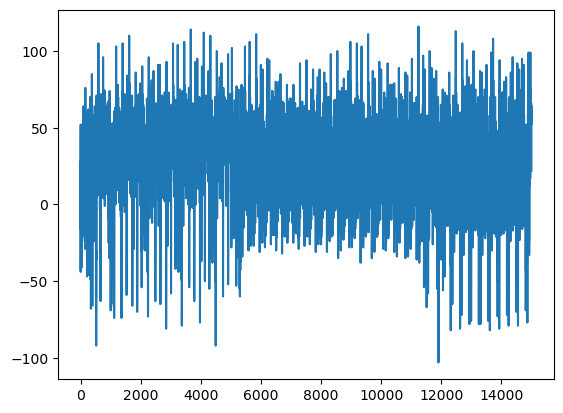

In [ ]:
path = 'dataset/ASCAD_data/ASCAD_databases/ascadv2-extracted.h5'

ascad_db = h5py.File(path, 'r')
profiling_traces = ascad_db['Profiling_traces']
attack_traces = ascad_db['Attack_traces']

X_test = attack_traces['traces']
metadata_test = attack_traces['metadata']
pt_test = metadata_test['plaintext']
key_test = metadata_test['key']
Y_test = attack_traces['labels']

plt.figure()
plt.plot(profiling_traces['traces'][0])
plt.show()

In [ ]:
metadata_profiling = profiling_traces['metadata']
inds = metadata_profiling['key']

500000


## Generating the Labels

The cell below generates the non-worst-case labels for ASCADv2 as per Appendix F.1.

In [ ]:
byte = 4
labels, pts, keys = construct_labels(byte, profiling_traces)
labels_attack, pts_attack, keys_attack = construct_labels(byte, attack_traces)

[ 6  5 10  8  2 12  4  0 13  7 14 11  3 15  1  9]


Constructing labels:   0%|          | 0/500000 [00:00<?, ?it/s]

Constructing labels: 100%|██████████| 10000/10000 [00:00<00:00, 2711600.72it/s]


## Splitting the Dataset

See section 6.3.1 of the paper for more details.

In [6]:
train_len = 200000
test_len = 1000

X = torch.Tensor(np.array(profiling_traces['traces'][:train_len]))
Y = torch.LongTensor(labels[:train_len])

X_attack = torch.Tensor(np.array(attack_traces['traces'][:test_len]))
Y_attack = torch.LongTensor(labels_attack[:test_len])

# Training the Model

In [ ]:
n_classes = 256
signal_length = len(X[0])
lr = 1e-4
beta1 = 0.965
beta2 = 0.999
n_epochs = 150
activation = 'ReLU'
n_linear = 1
linear_size = math.ceil(signal_length+n_classes*(2/3))
input_bn = True
dense_bn = False
batch_size = 32
weight_decay = 0.2

train_loader = FastTensorDataLoader(X, Y, batch_size=batch_size, shuffle=True)

attack_loader = FastTensorDataLoader(X_attack, Y_attack, batch_size=batch_size, shuffle=False)


model = MLPModel(signal_length=signal_length, n_classes=n_classes, n_linear=n_linear, linear_size=linear_size, activation=activation, input_bn=input_bn, dense_bn=dense_bn).to(device)
optimizer = Scoop(model.parameters(), lr=lr, betas=(beta1, beta2), weight_decay=weight_decay, estimator='low_variance', hessian_iter=1)

path_model = 'ascadv2_singlemlp.pt'
train_loss, val_loss, _ = train_model(model, optimizer, n_epochs, train_loader, attack_loader, verbose=True, path=path_model, device=device, MLP=False, finetuning=True, entropy=8)



/home/nrousselot/miniconda3/envs/curse_of_masking/lib/python3.11/site-packages/torch/autograd/graph.py:825: UserWarning: Using backward() with create_graph=True will create a reference cycle between the parameter and its gradient which can cause a memory leak. We recommend using autograd.grad when creating the graph to avoid this. If you have to use this function, make sure to reset the .grad fields of your parameters to None after use to break the cycle and avoid the leak. (Triggered internally at /opt/conda/conda-bld/pytorch_1729647429097/work/torch/csrc/autograd/engine.cpp:1201.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/150 | Train loss: 8.0057 | Valid loss: 7.9999 | Expected time left: 175606.66 s
Epoch 2/150 | Train loss: 7.9999 | Valid loss: 7.9999 | Expected time left: 174511.29 s
Epoch 3/150 | Train loss: 7.9999 | Valid loss: 7.9999 | Expected time left: 173300.49 s
Epoch 4/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 172105.42 s
Epoch 5/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 170917.76 s
Epoch 6/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 169731.95 s
Epoch 7/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 168548.85 s
Epoch 8/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 167366.78 s
Epoch 9/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 166185.32 s
Epoch 10/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 165004.57 s
Epoch 11/150 | Train loss: 7.9999 | Valid loss: 8.0000 | Expected time left: 163824.15 s
Epoch 12/150 | Train loss: 7.9

KeyboardInterrupt: 